In [1]:
from functools import partial
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from cirq import(
    NoiseModel,
    BitFlipChannel,
    PhaseFlipChannel,
)

from mitiq import zne
from mitiq.benchmarks import generate_rb_circuits
from mitiq.zne.scaling import fold_global

In [2]:
def gen_noise_model(PERR, distance):
    """Create sweepable Pauli noise model."""
    PTH = 0.009
    LERR = 0.03 * (PERR / PTH) ** int((distance + 1) / 2)
    return LERR # model as single-qubit errors remaining after correction 


class PauliNoiseModel(NoiseModel):

    def __init__(self, error_rate):
        self.error_rate = error_rate

    def noisy_operation(self, op):
        error_rate = self.error_rate
        channel = BitFlipChannel(error_rate).on_each(op.qubits)
        channel += PhaseFlipChannel(error_rate).on_each(op.qubits)
        return [op, channel]

In [3]:
num_trials = 100

base_shots = 10000
device_size = 1200
p_err=0.006
n_qubits = 2
correct_bitstring = [0] * n_qubits
depth = 20

scale_factors = [1, 3, 5, 7]
fac = zne.PolyFactory(scale_factors, order=3)

d_array = [21, 19, 17, 15, 13, 11, 9, 7, 5]

In [4]:
def calculate_folding_exp_vals(scale_factors, exp_vals, num_trials):
    """Perform extrapolation to zero noise limit on expectation values obtained
    with noise scaling by unitary folding. Return mean and standard deviation
    of the ZNE expectation values.
    """
    folding_values = np.zeros((num_trials, 1))

    for trial in range(num_trials):
        folding_values[trial] = fac.extrapolate(scale_factors, exp_vals[trial, : -1], order=3)

    return [np.mean(folding_values), np.std(folding_values)]

In [5]:
def distance_extrapolation(distance_scale_factors, ds_expectation_values):
    fac = zne.PolyFactory(scale_factors=distance_scale_factors, order=3)
    for s, v in zip(distance_scale_factors, ds_expectation_values):
        fac.push({"scale_factor": s}, v)
    result = fac.reduce()
    # _ = fac.plot_fit()
    return result

In [6]:
def calculate_ds_exp_vals(d_array, distance_indices, exp_vals, num_trials):
    """Perform extrapolation to zero noise limit on expectation values obtained
    with noise scaling by unitary folding. Return mean and standard deviation
    of the ZNE expectation values.
    """
    ds_values = np.zeros((num_trials, len(distance_indices)))
    # distance_scale_factors = [gen_noise_model(p_err, d_array[d]) / gen_noise_model(p_err, d_array[distance_indices[0][0]]) for d in distance_indices[0]]

    for count, d_ind in enumerate(distance_indices):
        distance_scale_factors = [gen_noise_model(p_err, d_array[di]) / gen_noise_model(p_err, d_array[d_ind[0]]) for di in d_ind]
        for trial in range(num_trials):
            ds_values[trial, count] = distance_extrapolation(distance_scale_factors, exp_vals[trial, d_ind])

    return [np.mean(ds_values, axis=0), np.std(ds_values, axis=0)]


In [7]:
exp_vals_depth20 = np.zeros((num_trials, len(scale_factors) + 1, len(d_array)))

folding_exp_vals_depth20 = np.zeros((len(d_array)-3, 2))
distance_indices = [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8]]
for d_ind in range(len(d_array) - 3):
    exp_vals_depth20[:, :, d_ind] = np.loadtxt(os.path.join("./data", f"depth20_distance{d_array[d_ind]}.txt"))
    folding_exp_vals_depth20[d_ind, :] = (calculate_folding_exp_vals(scale_factors, exp_vals_depth20[:, :, d_ind], num_trials))

for d_ind in range(len(d_array)-3, len(d_array)):
    exp_val = np.loadtxt(os.path.join("./data", f"depth20_distance{d_array[d_ind]}.txt"))
    exp_vals_depth20[:, 0, d_ind] = exp_val[:, 0]

ds_exp_vals_depth20 = calculate_ds_exp_vals(d_array, distance_indices, exp_vals_depth20[:, 0, :], num_trials)

In [9]:
# LaTeX setup
plt.rcParams['text.latex.preamble'] = r'\usepackage{mathptmx}'
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['text.usetex'] = True

WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


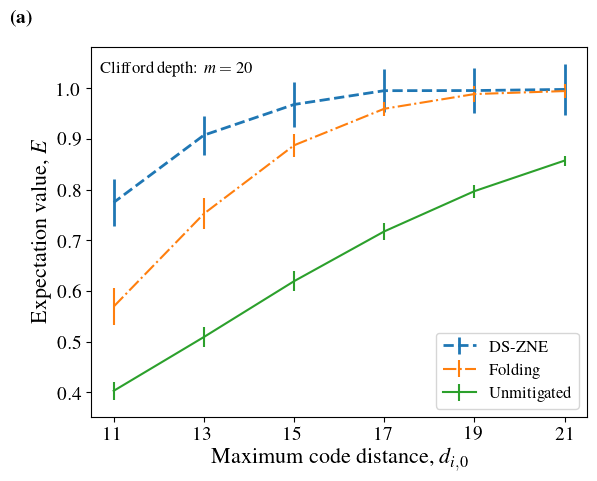

In [11]:
## Plot of expectation values for each set of distances
plt.errorbar(d_array[0:6], ds_exp_vals_depth20[0], yerr=ds_exp_vals_depth20[1], ls='--', label='DS-ZNE', lw=2)
plt.errorbar(d_array[0:6], folding_exp_vals_depth20[:, 0], yerr=folding_exp_vals_depth20[:, 1], ls = '-.',label='Folding')
plt.errorbar(d_array[0:6], np.mean(exp_vals_depth20[:, 4, 0:6], axis=0), yerr=np.std(exp_vals_depth20[:, 4, 0:6], axis=0), label='Unmitigated')

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='serif', style='normal', size=12)
plt.xlabel(r'Maximum code distance, $d_{i,0}$', family='serif', fontsize=16)
plt.ylabel(r'Expectation value, $E$', family='serif', fontsize=16)
plt.xticks(ticks = [11, 13, 15, 17, 19, 21], family='serif', fontsize=14)
plt.yticks(family='serif', fontsize=14)
plt.legend(loc='lower right', prop=font)
plt.text(10.7, 1.03,'Clifford depth: $m = 20$', family='serif', fontsize=12)
plt.text(8.7, 1.13, r"\textbf{(a)}", weight='bold', fontsize=14, family='serif')
rc('font', **{'family': 'serif', 'serif': ['Times']})
rc('text', usetex=True)
plt.savefig("depth_20_exp_vals.eps",format = 'eps', bbox_inches="tight")
plt.show()

In [ ]:
def compare_numerical_results(ds_exp_vals, folding_exp_vals, unmitigated_exp_vals):
    ds_error = np.abs(np.ones((len(ds_exp_vals[0]))) -  ds_exp_vals[0])
    folding_error = np.abs(np.ones((len(folding_exp_vals[:, 0]))) - folding_exp_vals[:, 0])
    delta_error = ds_error - folding_error
    unmitigated_mean_vals = np.mean(unmitigated_exp_vals, axis=0)
    unmitigated_error = np.abs(np.ones(len(unmitigated_mean_vals))-unmitigated_mean_vals)
    ds_error_reduction = np.divide((ds_error - unmitigated_error), unmitigated_error)
    folding_error_reduction = np.divide((folding_error - unmitigated_error), unmitigated_error)
    ds_std = ds_exp_vals[1]
    unmitigated_std = np.std(unmitigated_exp_vals, axis=0)
    std_ratio = np.divide(np.array(ds_std) - np.array(unmitigated_std), np.array(unmitigated_std))
    error_reduction_ratio = np.divide(delta_error, folding_error)
    return np.min(ds_error_reduction), np.min(folding_error_reduction), np.min(error_reduction_ratio), np.max(std_ratio)

In [ ]:
compare_numerical_results(ds_exp_vals_depth20, folding_exp_vals_depth20, exp_vals_depth20[:, 4, 0:6])

(-0.9870633604007159,
 -0.9643888506344681,
 -0.8922950725675699,
 4.047527356882633)

In [ ]:
num_trials = 100

base_shots = 10000
device_size = 1200
p_err=0.006
n_qubits = 2
correct_bitstring = [0] * n_qubits
depth = 30

scale_factors = [1, 3, 5, 7]
fac = zne.PolyFactory(scale_factors, order=3)

d_array = [21, 19, 17, 15, 13, 11, 9, 7, 5]

In [13]:
exp_vals_depth30 = np.zeros((num_trials, len(scale_factors) + 1, len(d_array)))

folding_exp_vals_depth_30 = np.zeros((len(d_array)-3, 2))
distance_indices = [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8]]

for d_ind in range(len(d_array) - 3):
    exp_vals_depth30[:, :, d_ind] = np.loadtxt(os.path.join("./data", f"depth30_distance{d_array[d_ind]}.txt"))
    folding_exp_vals_depth_30[d_ind, :] = (calculate_folding_exp_vals(scale_factors, exp_vals_depth30[:, :, d_ind], num_trials))

for d_ind in range(len(d_array)-3, len(d_array)):
    exp_val = np.loadtxt(os.path.join("./data", f"depth30_distance{d_array[d_ind]}.txt"))
    exp_vals_depth30[:, 0, d_ind] = exp_val[:, 0]

ds_exp_vals_depth30 = calculate_ds_exp_vals(d_array, distance_indices, exp_vals_depth30[:, 0, :], num_trials)

WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


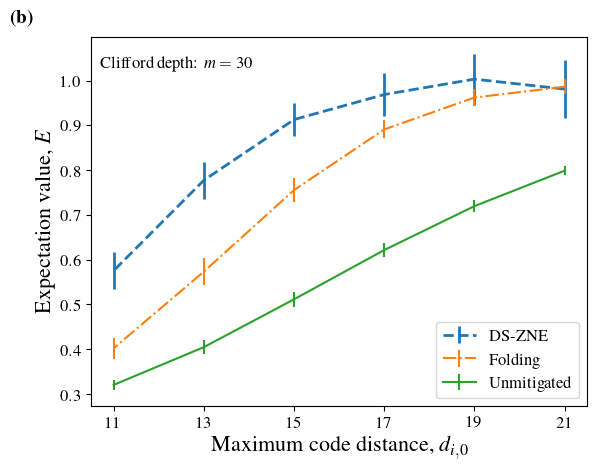

In [14]:
## Plot of expectation values for each set of distances
plt.errorbar(d_array[0:6], ds_exp_vals_depth30[0], yerr=ds_exp_vals_depth30[1], ls='--', label='DS-ZNE', lw=2)
plt.errorbar(d_array[0:6], folding_exp_vals_depth_30[:, 0], yerr=folding_exp_vals_depth_30[:, 1], ls = '-.',label='Folding')
plt.errorbar(d_array[0:6], np.mean(exp_vals_depth30[:, 4, 0:6], axis=0), yerr=np.std(exp_vals_depth30[:, 4, 0:6], axis=0), label='Unmitigated')

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties( size=12)
plt.xlabel(r'Maximum code distance, $d_{i,0}$', fontsize=16)
plt.ylabel(r'Expectation value, $E$', fontsize=16)
plt.xticks(ticks = [11, 13, 15, 17, 19, 21], fontsize=12)
plt.yticks(family='serif', fontsize=12)
plt.legend(loc='lower right', prop=font)
plt.text(10.7, 1.03,'Clifford depth: $m = 30$', fontsize=12)
plt.text(8.7, 1.13, r"\textbf{(b)}", fontsize=14)
rc('font', **{'family': 'serif', 'serif': ['Times']})
rc('text', usetex=True)
plt.savefig("depth_30_exp_vals.eps", format = 'eps', bbox_inches="tight")
plt.show()

In [ ]:
compare_numerical_results(ds_exp_vals_depth30, folding_exp_vals_depth_30, exp_vals_depth30[:, 4, 0:6])

(-0.9886228923307586,
 -0.9315866889122667,
 -0.9157639942570703,
 5.149515614378712)

/var/folders/mc/x5spc52d2nq_q5x2xpg3r77m0000gn/T/ipykernel_16789/718460318.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.collections[0].colorbar.set_ticklabels(ticklabels=[0, 10, 20, 30, 40, 50], fontfamily="serif", fontsize=9)


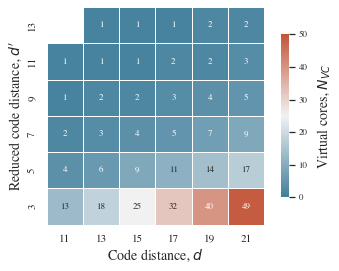

In [ ]:
import seaborn as sns
from matplotlib import rc

sns.set_theme(style="white")


d = np.linspace(11, 21, 6, dtype=int)
d_prime = d - 8 * np.ones(len(d), dtype=int)
inv_d_prime_sq = 1 / (d_prime)**2

cores = np.floor(np.outer((d**2), (inv_d_prime_sq))).transpose()

# Generate a mask for the upper triangle
mask = np.zeros_like(cores, dtype=bool)

mask[-1, 0] = True


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(cores, cmap=cmap, mask=mask, vmin=0, vmax=50,
             square=True, linewidths=.5, cbar_kws={"shrink": .75}, annot=True, annot_kws={"fontfamily": "serif", "fontsize": 9})
ax.invert_yaxis()
ax.set_xticklabels(d, fontfamily="serif", fontsize=11)
ax.set_yticklabels(d_prime, fontfamily="serif", fontsize=11)
ax.set_xlabel(r"Code distance, $d$", fontfamily="serif", fontsize=14)
ax.set_ylabel(r"Reduced code distance, $d'$", fontfamily="serif", fontsize=14)
ax.collections[0].colorbar.set_label(r"Virtual cores, $N_{VC}$", fontfamily="serif", labelpad=8, fontsize=14)
ax.collections[0].colorbar.set_ticklabels(ticklabels=[0, 10, 20, 30, 40, 50], fontfamily="serif", fontsize=9)

rc('font', **{'family': 'serif', 'serif': ['Times']})
rc('text', usetex=True)
plt.savefig("heatmap.eps", format = 'eps', bbox_inches="tight")
